## House Price Prediction using Linear Regression with Gradient Descent
## A Complete End-to-End Machine Learning Project

## Table of Contents
1. Introduction & Problem Statement
2. Data Loading & Exploration
3. Missing Data Analysis
4. Feature Engineering
5. Feature Encoding
6. Correlation Analysis & Feature Selection
7. Multicollinearity Detection (VIF)
8. Test Data Preprocessing
9. Data Scaling
10. Linear Regression from Scratch
11. Model Training & Prediction

# 1. Introduction

## Objective
This notebook implements a **Linear Regression model from scratch** to predict 
house sale prices using the Ames Housing dataset. We'll use **Gradient Descent** 
with **L2 Regularization (Ridge Regression)** to train our model.

## Mathematical Foundation

### Linear Regression Model
The hypothesis function is:
    h_θ(x) = θ₀ + θ₁x₁ + θ₂x₂ + ... + θₙxₙ = θᵀx

Where:
- θ = [θ₀, θ₁, ..., θₙ] are the model parameters (weights)
- x = [1, x₁, x₂, ..., xₙ] is the feature vector (with bias term)
- θ₀ is the bias/intercept term

### Cost Function (Mean Squared Error with L2 Regularization)
    J(θ) = (1/2m) Σᵢ₌₁ᵐ (h_θ(x⁽ᶦ⁾) - y⁽ᶦ⁾)² + (λ/2m) Σⱼ₌₁ⁿ θⱼ²

Where:
- m = number of training examples
- λ = regularization parameter (controls overfitting)
- The second term is the L2 penalty (Ridge regularization)

### Gradient Descent Update Rule
    θⱼ := θⱼ - α · ∂J(θ)/∂θⱼ

Where:
- α = learning rate (step size)
- ∂J(θ)/∂θⱼ = (1/m) Σᵢ₌₁ᵐ (h_θ(x⁽ᶦ⁾) - y⁽ᶦ⁾)xⱼ⁽ᶦ⁾ + (λ/m)θⱼ

## Why Log Transform the Target?
We use log(SalePrice) instead of raw SalePrice because:
1. House prices are right-skewed (exponential distribution)
2. Log transformation makes the distribution more normal (Gaussian)
3. Linear regression assumes normally distributed residuals
4. Final predictions: SalePrice = exp(prediction)

In [129]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load datasets
df = pd.read_csv("train.csv")
df2 = pd.read_csv("test.csv")

print("=" * 70)
print("DATA OVERVIEW")
print("=" * 70)
print(f"Training Set Shape (rows, cols): {df.shape}")
print(f"Test Set Shape (rows, cols): {df2.shape}")
print("\n" + "="*70)
print("FIRST 5 ROWS OF TRAINING DATA")
print("=" * 70)
display(df.head())

print("\n" + "="*70)
print("DATASET INFORMATION")
print("=" * 70)
display(df.info())



DATA OVERVIEW
Training Set Shape (rows, cols): (1460, 81)
Test Set Shape (rows, cols): (1459, 80)

FIRST 5 ROWS OF TRAINING DATA


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   

None

# 3. Missing Data Analysis

Missing data can significantly impact model performance. We identify features with 
high missing percentages and decide on appropriate strategies:
- **Drop features** with >50% missing values
- **Impute** remaining missing values using domain knowledge


MISSING DATA ANALYSIS
Features with missing values (sorted by percentage):



PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

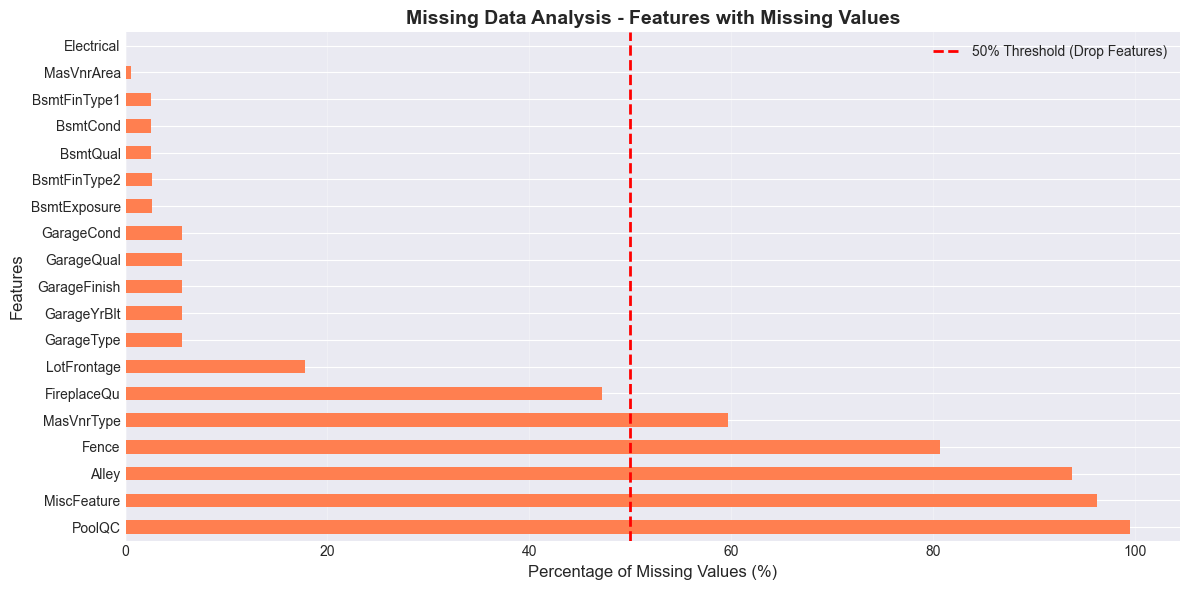

In [130]:
print("\n" + "="*70)
print("MISSING DATA ANALYSIS")
print("=" * 70)
print("Features with missing values (sorted by percentage):\n")

missing = df.isnull().mean() * 100
missing_features = missing[missing > 0].sort_values(ascending=False)
display(missing_features)

# Visualize missing data
plt.figure(figsize=(12, 6))
missing_features.plot(kind='barh', color='coral')
plt.xlabel('Percentage of Missing Values (%)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Missing Data Analysis - Features with Missing Values', 
          fontsize=14, fontweight='bold')
plt.axvline(x=50, color='red', linestyle='--', linewidth=2, 
            label='50% Threshold (Drop Features)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()



# 4. Statistical Summary & Target Distribution

## Numerical Features Summary
We examine descriptive statistics (mean, std, min, max, quartiles) to understand
the range and distribution of numerical features.

## Target Variable Analysis
The target variable (SalePrice) often exhibits right-skewness, which violates
the normality assumption of linear regression.


NUMERICAL FEATURES - DESCRIPTIVE STATISTICS


,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0



TOP 20 FEATURES MOST CORRELATED WITH SALEPRICE

Pearson Correlation Coefficient (r):
  r = Σ[(xᵢ - x̄)(yᵢ - ȳ)] / √[Σ(xᵢ - x̄)² · Σ(yᵢ - ȳ)²]

Interpretation:
  |r| > 0.7: Strong correlation
  0.4 < |r| < 0.7: Moderate correlation
  |r| < 0.4: Weak correlation



SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
Name: SalePrice, dtype: float64

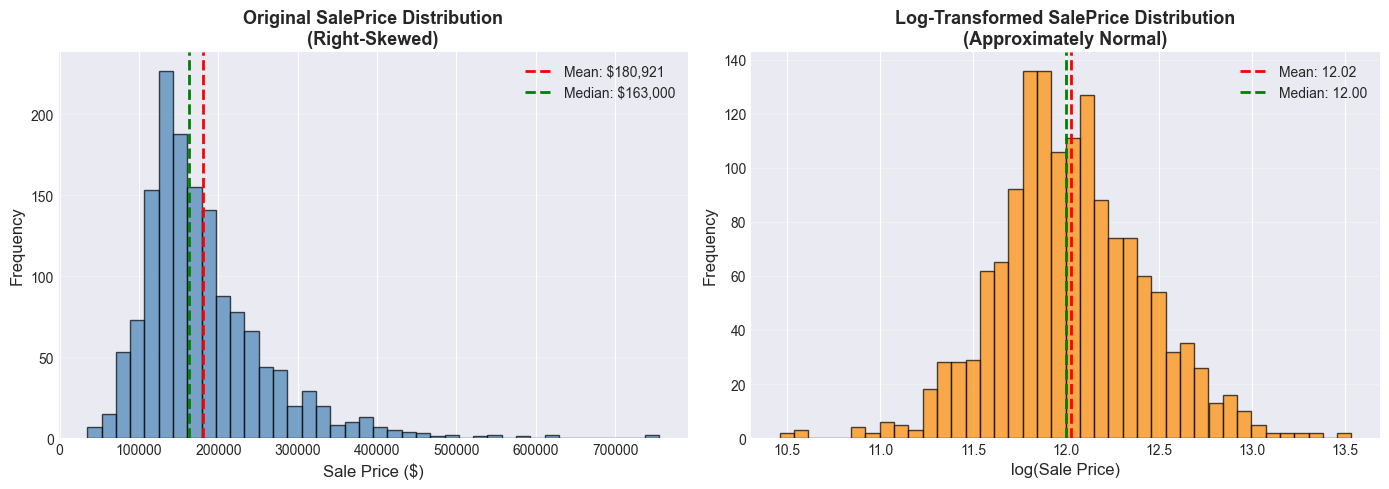

In [131]:
print("\n" + "="*70)
print("NUMERICAL FEATURES - DESCRIPTIVE STATISTICS")
print("=" * 70)
display(df.select_dtypes(include=np.number).describe().T)

# Correlation with target
correlation = df.select_dtypes(include=np.number).corr()
print("\n" + "="*70)
print("TOP 20 FEATURES MOST CORRELATED WITH SALEPRICE")
print("=" * 70)
print("\nPearson Correlation Coefficient (r):")
print("  r = Σ[(xᵢ - x̄)(yᵢ - ȳ)] / √[Σ(xᵢ - x̄)² · Σ(yᵢ - ȳ)²]")
print("\nInterpretation:")
print("  |r| > 0.7: Strong correlation")
print("  0.4 < |r| < 0.7: Moderate correlation")
print("  |r| < 0.4: Weak correlation\n")
display(correlation["SalePrice"].sort_values(ascending=False).head(20))

# Visualize SalePrice distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original SalePrice
axes[0].hist(df["SalePrice"], bins=40, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sale Price ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Original SalePrice Distribution\n(Right-Skewed)', 
                  fontsize=13, fontweight='bold')
axes[0].axvline(df["SalePrice"].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: ${df["SalePrice"].mean():,.0f}')
axes[0].axvline(df["SalePrice"].median(), color='green', linestyle='--', 
                linewidth=2, label=f'Median: ${df["SalePrice"].median():,.0f}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Log-transformed SalePrice
df["LogSalePrice"] = np.log(df["SalePrice"])
axes[1].hist(df["LogSalePrice"], bins=40, color='darkorange', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('log(Sale Price)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Log-Transformed SalePrice Distribution\n(Approximately Normal)', 
                  fontsize=13, fontweight='bold')
axes[1].axvline(df["LogSalePrice"].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {df["LogSalePrice"].mean():.2f}')
axes[1].axvline(df["LogSalePrice"].median(), color='green', linestyle='--', 
                linewidth=2, label=f'Median: {df["LogSalePrice"].median():.2f}')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



Key Insight: Log transformation normalizes the distribution, making it suitable
for linear regression which assumes normally distributed errors.

# 5. Data Cleaning Strategy

## Features to Drop (>80% missing):
- PoolQC, MiscFeature, Alley, Fence, MasVnrType

## Imputation Strategies:
1. **Categorical features**: Fill with "Missing" (indicates absence)
2. **LotFrontage**: Group by Neighborhood, fill with median (location-based)
3. **GarageYrBlt**: Fill with overall median
4. **MasVnrArea**: Drop rows (minimal loss, <1% of data)

In [132]:
print("\n" + "="*70)
print("DATA CLEANING")
print("=" * 70)

# Drop high-missing features
df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType'], 
        inplace=True, errors='ignore')
print("✓ Dropped features with >80% missing values")

# Fill categorical nulls
cat_cols = df.select_dtypes(include=object).columns
df[cat_cols] = df[cat_cols].fillna("Missing")
print(f"✓ Filled {len(cat_cols)} categorical features with 'Missing'")

# Fill LotFrontage by neighborhood median
df['LotFrontage'] = pd.to_numeric(df['LotFrontage'], errors='coerce')
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)
print("✓ Imputed LotFrontage using neighborhood-specific medians")

# Fill GarageYrBlt with median
df["GarageYrBlt"] = df["GarageYrBlt"].fillna(df["GarageYrBlt"].median())
print("✓ Imputed GarageYrBlt with overall median")

# Drop rows with missing MasVnrArea
rows_before = len(df)
df.dropna(subset=["MasVnrArea"], inplace=True)
print(f"✓ Dropped {rows_before - len(df)} rows with missing MasVnrArea")

print(f"\n Final training set shape: {df.shape}")

# ==============================================================================
# 6. FEATURE ENGINEERING
# ==============================================================================


DATA CLEANING
✓ Dropped features with >80% missing values
✓ Filled 38 categorical features with 'Missing'
✓ Imputed LotFrontage using neighborhood-specific medians
✓ Imputed GarageYrBlt with overall median
✓ Dropped 8 rows with missing MasVnrArea

 Final training set shape: (1452, 77)


# 6. Feature Engineering

Creating new features from existing ones can improve model performance by 
capturing domain-specific relationships.

## New Features:
1. **TotalSF**: Total square footage = Basement + 1st Floor + 2nd Floor
   - Rationale: Overall size is a strong price predictor
   
2. **HouseAge**: Age at sale = YrSold - YearBuilt
   - Rationale: Newer houses typically sell for more
   
3. **RemodAge**: Time since remodeling = YrSold - YearRemodAdd
   - Rationale: Recent renovations increase value
   
4. **HasPool**: Binary indicator (1 if PoolArea > 0, else 0)
   - Rationale: Pools add value but are rare (categorical representation)

In [133]:
print("\n" + "="*70)
print("FEATURE ENGINEERING")
print("=" * 70)

df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df.get('2ndFlrSF', 0)
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
df['HasPool'] = (df['PoolArea'] > 0).astype(int)

print("✓ Created 4 new engineered features:")
print("  - TotalSF (Total Square Footage)")
print("  - HouseAge (Years since construction)")
print("  - RemodAge (Years since last remodel)")
print("  - HasPool (Binary pool indicator)")

# Display examples
print("\nSample of new features:")
display(df[['TotalSF', 'HouseAge', 'RemodAge', 'HasPool', 'SalePrice']].head())



FEATURE ENGINEERING
✓ Created 4 new engineered features:
  - TotalSF (Total Square Footage)
  - HouseAge (Years since construction)
  - RemodAge (Years since last remodel)
  - HasPool (Binary pool indicator)

Sample of new features:


,TotalSF,HouseAge,RemodAge,HasPool,SalePrice
0,2566,5,5,0,208500
1,2524,31,31,0,181500
2,2706,7,6,0,223500
3,2473,91,36,0,140000
4,3343,8,8,0,250000


# 7. Feature Encoding

Machine learning models require numerical input. We encode categorical variables:

## Ordinal Encoding
For features with inherent order (e.g., quality ratings):
    ExterQual: Excellent(5) > Good(4) > Typical(3) > Fair(2) > Poor(1)

Mathematical representation:
    x_ordinal ∈ {1, 2, 3, 4, 5} where higher values = better quality

## One-Hot Encoding
For nominal features without order (e.g., Neighborhood):
    Original: ['Neighborhood'] = 'CollgCr'
    Encoded: ['Neighborhood_CollgCr'=1, 'Neighborhood_OldTown'=0, ...]

This creates binary features: x_i ∈ {0, 1}

Encodes categorical features using ordinal and one-hot encoding.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with categorical features
        
    Returns:
    --------
    df : pandas.DataFrame
        DataFrame with encoded features

In [134]:
def encode_features(df):
    print("\n  Encoding Process:")
        
        # ===== ORDINAL FEATURES =====
    ordinal_mappings = {
            'ExterQual': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'ExterCond': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'BsmtQual': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'BsmtCond': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'BsmtExposure': {'Gd':4, 'Av':3, 'Mn':2, 'No':1},
            'BsmtFinType1': {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1},
            'BsmtFinType2': {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1},
            'HeatingQC': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'KitchenQual': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'FireplaceQu': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'GarageQual': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'GarageCond': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'Functional': {'Typ':8, 'Min1':7, 'Min2':6, 'Mod':5, 'Maj1':4, 'Maj2':3, 'Sev':2, 'Sal':1},
            'PavedDrive': {'Y':3, 'P':2, 'N':1},
            'CentralAir': {'Y':1, 'N':0},
            'LandSlope': {'Gtl':3, 'Mod':2, 'Sev':1},
            'LotShape': {'Reg':4, 'IR1':3, 'IR2':2, 'IR3':1},
            'GarageFinish': {'Fin':3, 'RFn':2, 'Unf':1, 'No garage':0},
            'Street': {'Pave':2, 'Grvl':1}
        }
        
        # Apply ordinal mapping
    ordinal_count = 0
    for col, mapping in ordinal_mappings.items():
        if col in df.columns:
                df[col] = df[col].map(mapping).fillna(0)
                ordinal_count += 1
        print(f"  ✓ Ordinal encoded {ordinal_count} features")
        
        # ===== NOMINAL FEATURES =====
        nominal_features = [
            'MSSubClass','MSZoning','Neighborhood','Condition1','Condition2','BldgType',
            'HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','Foundation',
            'Heating','Electrical','GarageType','SaleType','SaleCondition','Utilities',
            'LandContour','LotConfig'
        ]
        
        # Apply one-hot encoding
        cols_to_encode = [col for col in nominal_features if col in df.columns]
        df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)
        print(f"  ✓ One-hot encoded {len(cols_to_encode)} nominal features")
        
        # Convert boolean columns to int
        bool_cols = df.select_dtypes(include='bool').columns
        for col in bool_cols:
            df[col] = df[col].astype(int)
        
        return df

print("\n" + "="*70)
print("ENCODING CATEGORICAL FEATURES")
print("=" * 70)

encoded_df = encode_features(df)
print(f"\n  Final encoded dataset shape: {encoded_df.shape}")
print(f"  Number of features after encoding: {encoded_df.shape[1]}")

print("\nSample of encoded features:")
display(encoded_df.head())



ENCODING CATEGORICAL FEATURES

  Encoding Process:
  ✓ Ordinal encoded 1 features
  ✓ One-hot encoded 20 nominal features

  Final encoded dataset shape: (1452, 212)
  Number of features after encoding: 212

Sample of encoded features:


,Id,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleCondition_Normal,SaleCondition_Partial,Utilities_NoSeWa,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside
0,1,65.0,8450,Pave,Reg,Gtl,7,5,2003,2003,...,1,0,0,0,0,1,0,0,0,1
1,2,80.0,9600,Pave,Reg,Gtl,6,8,1976,1976,...,1,0,0,0,0,1,0,1,0,0
2,3,68.0,11250,Pave,IR1,Gtl,7,5,2001,2002,...,1,0,0,0,0,1,0,0,0,1
3,4,60.0,9550,Pave,IR1,Gtl,7,5,1915,1970,...,0,0,0,0,0,1,0,0,0,0
4,5,84.0,14260,Pave,IR1,Gtl,8,5,2000,2000,...,1,0,0,0,0,1,0,1,0,0


# 8. Feature Selection using Correlation

## Why Feature Selection?
- **Curse of Dimensionality**: Too many features can lead to overfitting
- **Computational Efficiency**: Fewer features = faster training
- **Interpretability**: Focus on most important predictors

## Correlation Threshold Method:
We select features with |correlation| > 0.3 with the target variable.

Mathematical Definition:
    Selected Features = {f : |ρ(f, y)| > 0.3}

Where ρ is the Pearson correlation coefficient.


FEATURE SELECTION - CORRELATION ANALYSIS

Top 15 features most correlated with SalePrice:


SalePrice           1.000000
LogSalePrice        0.948430
OverallQual         0.789997
TotalSF             0.783181
GrLivArea           0.710080
ExterQual           0.681161
GarageCars          0.639686
GarageArea          0.622492
TotalBsmtSF         0.612971
1stFlrSF            0.606849
FullBath            0.562491
TotRmsAbvGrd        0.536311
YearBuilt           0.522896
YearRemodAdd        0.507158
Foundation_PConc    0.497476
Name: SalePrice, dtype: float64


✓ Selected 35 features with |correlation| > 0.3
  Original features: 212
  Selected features: 35
  Dimensionality reduction: 83.5%


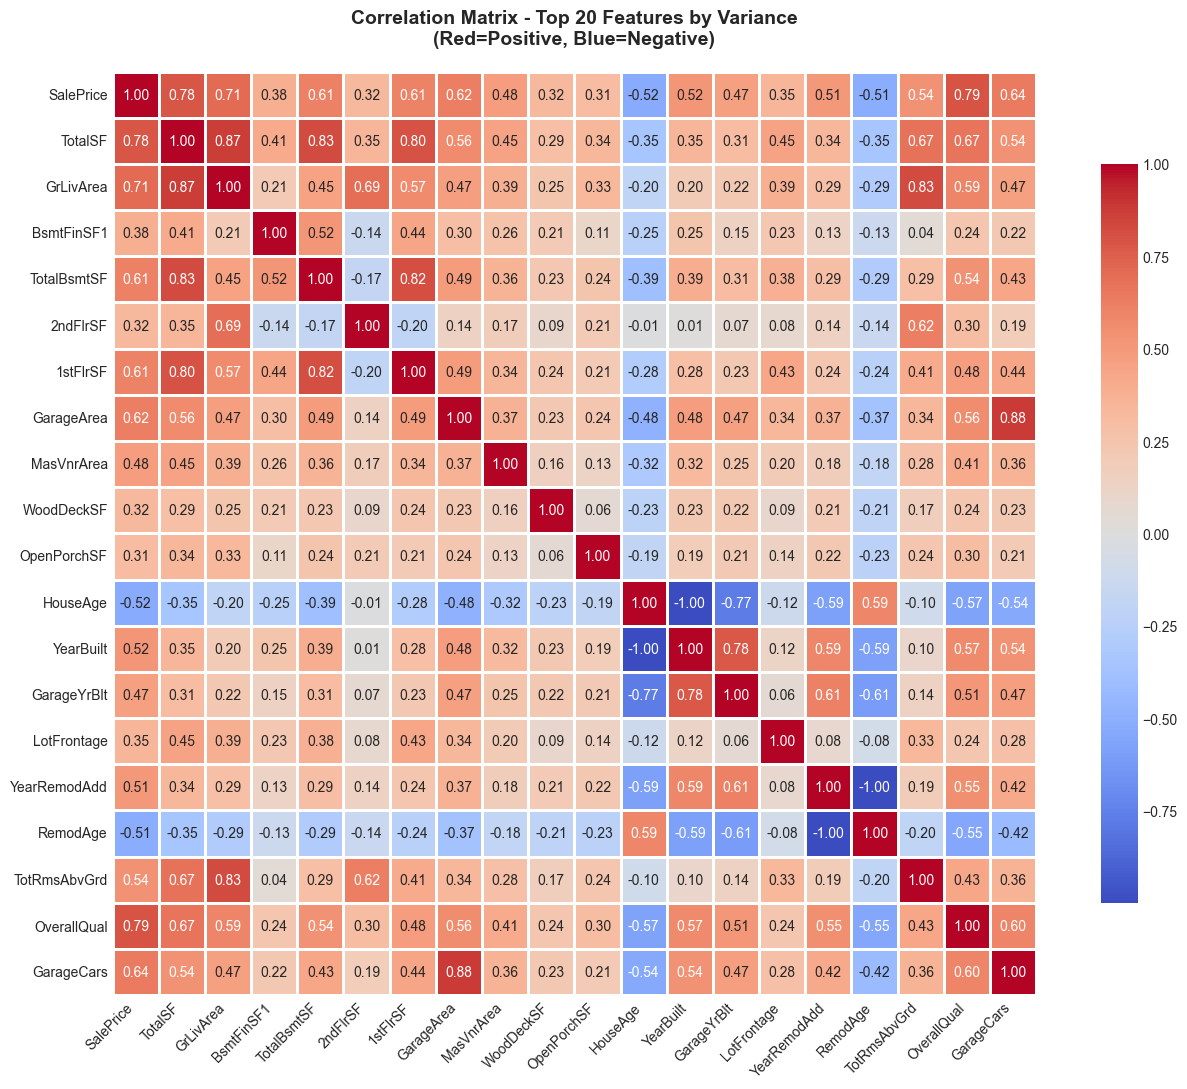

In [135]:
print("\n" + "="*70)
print("FEATURE SELECTION - CORRELATION ANALYSIS")
print("=" * 70)

# Compute correlations
corr = encoded_df.corr(numeric_only=True)
target_corr = corr['SalePrice'].sort_values(ascending=False)

print("\nTop 15 features most correlated with SalePrice:")
display(target_corr.head(15))

# Keep features with |correlation| > 0.3
correlation_threshold = 0.3
important_features = target_corr[abs(target_corr) > correlation_threshold].index
df_corr_selected = encoded_df[important_features]

print(f"\n✓ Selected {len(important_features)} features with |correlation| > {correlation_threshold}")
print(f"  Original features: {encoded_df.shape[1]}")
print(f"  Selected features: {df_corr_selected.shape[1]}")
print(f"  Dimensionality reduction: {((1 - df_corr_selected.shape[1]/encoded_df.shape[1])*100):.1f}%")

# Visualize correlation matrix
num_by_var = df_corr_selected.var().sort_values(ascending=False).head(20).index
corr_matrix = df_corr_selected[num_by_var].corr()

plt.figure(figsize=(14, 11))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Top 20 Features by Variance\n(Red=Positive, Blue=Negative)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



# 9. Variance Inflation Factor (VIF) Analysis

## What is Multicollinearity?
When predictor variables are highly correlated with each other, it causes:
- Unstable coefficient estimates
- Inflated standard errors
- Difficulty interpreting individual feature effects

## Variance Inflation Factor (VIF):
Measures how much the variance of a coefficient is inflated due to collinearity.

Mathematical Definition:
    VIF_j = 1 / (1 - R²_j)

Where R²_j is the R-squared from regressing feature j on all other features.

## Interpretation:
- VIF = 1: No correlation with other features
- VIF < 5: Acceptable
- 5 ≤ VIF < 10: Moderate multicollinearity
- VIF ≥ 10: High multicollinearity (consider removing feature)

## Rule of Thumb:
Remove features with VIF > 10 to reduce multicollinearity.


MULTICOLLINEARITY DETECTION - VIF ANALYSIS

Calculating VIF for all features...
(This may take a moment...)

VIF Results (sorted by severity):


c:\Users\aymen\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
1,TotalSF,inf
11,YearRemodAdd,inf
6,TotalBsmtSF,inf
7,1stFlrSF,inf
10,YearBuilt,inf
31,RemodAge,inf
25,2ndFlrSF,inf
32,HouseAge,inf
15,GarageYrBlt,2.407711e+04
2,GrLivArea,1.210922e+03



⚠ Found 22 features with VIF > 10 (multicollinearity issues)


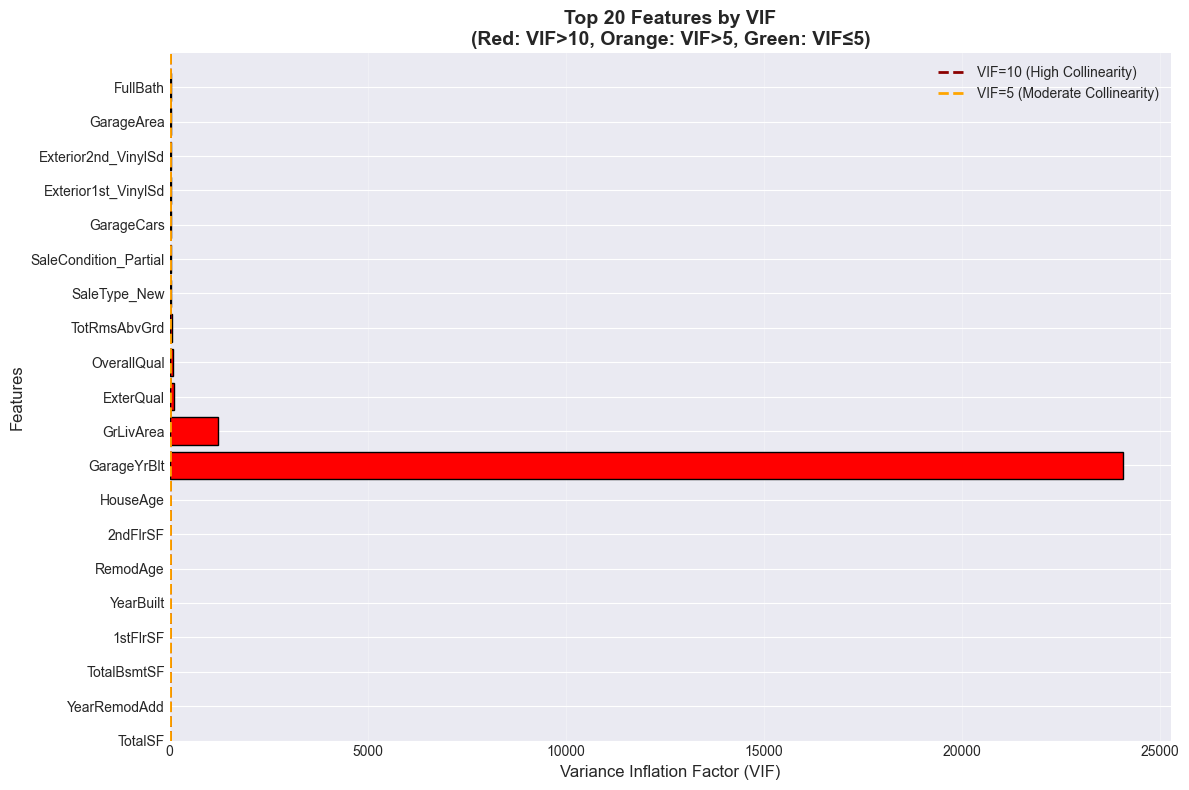


✓ Removed 5 high-VIF features:
  - GarageYrBlt
  - YearRemodAdd
  - 1stFlrSF
  - 2ndFlrSF
  - TotalBsmtSF

 Final feature set shape: (1452, 30)


C:\Users\aymen\AppData\Local\Temp\ipykernel_20576\1967267724.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_selected.drop(columns=columns_to_remove, inplace=True, errors="ignore")


In [136]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

print("\n" + "="*70)
print("MULTICOLLINEARITY DETECTION - VIF ANALYSIS")
print("=" * 70)

X = df_corr_selected.drop(columns=['SalePrice', 'LogSalePrice'], errors='ignore')

print("\nCalculating VIF for all features...")
print("(This may take a moment...)\n")

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)

print("VIF Results (sorted by severity):")
display(vif_data)

# Identify high-VIF features
high_vif = vif_data[vif_data['VIF'] > 10]
print(f"\n⚠ Found {len(high_vif)} features with VIF > 10 (multicollinearity issues)")

# Visualize VIF
plt.figure(figsize=(12, 8))
colors = ['red' if x > 10 else 'orange' if x > 5 else 'green' for x in vif_data['VIF'].head(20)]
plt.barh(range(20), vif_data['VIF'].head(20), color=colors, edgecolor='black')
plt.yticks(range(20), vif_data['Feature'].head(20))
plt.xlabel('Variance Inflation Factor (VIF)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 20 Features by VIF\n(Red: VIF>10, Orange: VIF>5, Green: VIF≤5)', 
          fontsize=14, fontweight='bold')
plt.axvline(x=10, color='darkred', linestyle='--', linewidth=2, label='VIF=10 (High Collinearity)')
plt.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='VIF=5 (Moderate Collinearity)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Remove high-VIF features
columns_to_remove = ["GarageYrBlt", "YearRemodAdd", "1stFlrSF", "2ndFlrSF", "TotalBsmtSF"]
df_corr_selected.drop(columns=columns_to_remove, inplace=True, errors="ignore")

print(f"\n✓ Removed {len(columns_to_remove)} high-VIF features:")
for col in columns_to_remove:
    print(f"  - {col}")

print(f"\n Final feature set shape: {df_corr_selected.shape}")


# 10. Test Data Preprocessing

## Critical Requirement:
The test set must undergo **identical transformations** as the training set:
1. Same feature drops
2. Same missing value imputations
3. Same feature engineering
4. Same encoding
5. Same feature selection
6. **Exact same features in exact same order**

## Feature Alignment:
- Add missing columns (present in train but not test) → fill with 0
- Remove extra columns (present in test but not train)
- Reorder columns to match training set exactly

In [137]:
print("\n" + "="*70)
print("TEST DATA PREPROCESSING")
print("=" * 70)

df2_processed = df2.copy()

print("\nStep 1: Dropping high-missing features...")
df2_processed.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType'], 
                   inplace=True, errors='ignore')

print("Step 2: Handling missing values...")
cat_cols_df2 = df2_processed.select_dtypes(include=object).columns
df2_processed[cat_cols_df2] = df2_processed[cat_cols_df2].fillna("Missing")

df2_processed['LotFrontage'] = pd.to_numeric(df2_processed['LotFrontage'], errors='coerce')
df2_processed["LotFrontage"] = df2_processed.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)
df2_processed["LotFrontage"] = df2_processed["LotFrontage"].fillna(df2_processed["LotFrontage"].median())
df2_processed["GarageYrBlt"] = df2_processed["GarageYrBlt"].fillna(df2_processed["GarageYrBlt"].median())
df2_processed.dropna(subset=["MasVnrArea"], inplace=True)

print("Step 3: Feature engineering...")
df2_processed['TotalSF'] = df2_processed['TotalBsmtSF'] + df2_processed['1stFlrSF'] + df2_processed.get('2ndFlrSF', 0)
df2_processed['HouseAge'] = df2_processed['YrSold'] - df2_processed['YearBuilt']
df2_processed['RemodAge'] = df2_processed['YrSold'] - df2_processed['YearRemodAdd']
df2_processed['HasPool'] = (df2_processed['PoolArea'] > 0).astype(int)

print("Step 4: Encoding features...")
encoded_df2 = encode_features(df2_processed.copy())

print("\nStep 5: Removing high-VIF features...")
columns_to_drop_from_df2 = ["GarageYrBlt", "YearRemodAdd", "1stFlrSF", "2ndFlrSF", "TotalBsmtSF"]
encoded_df2.drop(columns=columns_to_drop_from_df2, inplace=True, errors="ignore")

print("\nStep 6: Aligning features with training set...")
train_feature_cols = df_corr_selected.drop(columns=['SalePrice', 'LogSalePrice'], errors='ignore').columns

# Add missing columns
missing_cols = set(train_feature_cols) - set(encoded_df2.columns)
for col in missing_cols:
    encoded_df2[col] = 0
print(f"  ✓ Added {len(missing_cols)} missing columns (filled with 0)")

# Remove extra columns
extra_cols = set(encoded_df2.columns) - set(train_feature_cols)
encoded_df2.drop(columns=list(extra_cols), inplace=True, errors='ignore')
print(f"  ✓ Removed {len(extra_cols)} extra columns")

# Ensure correct order
df2_selected = encoded_df2[train_feature_cols]
print(f"\n✓ Test set successfully aligned with training set")
print(f"  Training features: {len(train_feature_cols)}")
print(f"  Test features: {len(df2_selected.columns)}")
print(f"  Match: {list(train_feature_cols) == list(df2_selected.columns)}")




TEST DATA PREPROCESSING

Step 1: Dropping high-missing features...
Step 2: Handling missing values...
Step 3: Feature engineering...
Step 4: Encoding features...

  Encoding Process:
  ✓ Ordinal encoded 1 features
  ✓ One-hot encoded 20 nominal features

Step 5: Removing high-VIF features...

Step 6: Aligning features with training set...
  ✓ Added 0 missing columns (filled with 0)
  ✓ Removed 167 extra columns

✓ Test set successfully aligned with training set
  Training features: 28
  Test features: 28
  Match: True


# 11. Feature Scaling

## Why Scale Features?
- Gradient descent converges faster with scaled features
- Features with large ranges can dominate the cost function
- Regularization (L2) works better with standardized features

## Z-Score Standardization:
    z = (x - μ) / σ

Where:
- μ = mean of feature
- σ = standard deviation of feature
- Result: z ~ N(0, 1) (approximately normal with mean 0, std 1)

## Critical Rule:
**Fit scaler on training data only!** Then transform both train and test.
This prevents data leakage from test set.

In [138]:
print("\n" + "="*70)
print("FEATURE SCALING")
print("=" * 70)

X_train = df_corr_selected.drop(columns=['SalePrice', 'LogSalePrice'], errors='ignore')
X_test = df2_selected.copy()
y_train = df_corr_selected['LogSalePrice']

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Target (log scale): {y_train.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on train only
X_test_scaled = scaler.transform(X_test)        # Transform test using train statistics

print("\n✓ Features standardized using Z-score normalization")
print(f"  Training set scaled shape: {X_train_scaled.shape}")
print(f"  Test set scaled shape: {X_test_scaled.shape}")

# Verify standardization
print("\nVerification (Training Set Statistics After Scaling):")
print(f"  Mean ≈ 0: {np.abs(X_train_scaled.mean(axis=0)).max():.6f} (max absolute mean)")
print(f"  Std ≈ 1: {np.abs(X_train_scaled.std(axis=0) - 1).max():.6f} (max deviation from 1)")




FEATURE SCALING

Training set: (1452, 28)
Test set: (1444, 28)
Target (log scale): (1452,)

✓ Features standardized using Z-score normalization
  Training set scaled shape: (1452, 28)
  Test set scaled shape: (1444, 28)

Verification (Training Set Statistics After Scaling):
  Mean ≈ 0: 0.000000 (max absolute mean)
  Std ≈ 1: 0.000000 (max deviation from 1)


# 12. Linear Regression Implementation

## Cost Function with L2 Regularization (Ridge Regression)

The cost function we minimize is:

    J(θ) = (1/2m) Σᵢ₌₁ᵐ (h_θ(x⁽ᶦ⁾) - y⁽ᶦ⁾)² + (λ/2m) Σⱼ₌₁ⁿ θⱼ²
    
Components:
- First term: Mean Squared Error (MSE) - measures prediction error
- Second term: L2 penalty - prevents large weights (reduces overfitting)
- λ (lambda): Regularization strength
  - λ = 0: Standard linear regression (no regularization)
  - λ > 0: Ridge regression (penalizes large coefficients)
  - λ → ∞: All coefficients shrink toward zero

## Gradient Descent Algorithm

For each parameter θⱼ, we update iteratively:

    θⱼ := θⱼ - α · ∂J(θ)/∂θⱼ
    
Where the gradient is:

    ∂J(θ)/∂θⱼ = (1/m) Σᵢ₌₁ᵐ (h_θ(x⁽ᶦ⁾) - y⁽ᶦ⁾)xⱼ⁽ᶦ⁾ + (λ/m)θⱼ   for j ≥ 1
    ∂J(θ)/∂θ₀ = (1/m) Σᵢ₌₁ᵐ (h_θ(x⁽ᶦ⁾) - y⁽ᶦ⁾)                 for j = 0 (bias)

Note: We don't regularize the bias term θ₀.

## Algorithm Parameters:
- **α (alpha)**: Learning rate - controls step size
  - Too large: May overshoot and diverge
  - Too small: Slow convergence
  - Typical values: 0.001 to 0.3
  
- **n_iters**: Number of iterations
  - Monitor cost to determine if more iterations are needed
  
- **λ (lambda)**: Regularization strength
  - Start with small values (0.01 to 1.0)
  - Tune via cross-validation for optimal performance

Computes the cost function for linear regression with L2 regularization.
    
    Parameters:
    -----------
    X : numpy.ndarray, shape (m, n+1)
        Feature matrix with bias column (m samples, n+1 features including bias)
    y : numpy.ndarray, shape (m,)
        Target values
    theta : numpy.ndarray, shape (n+1,)
        Model parameters
    l2_lambda : float, default=0.0
        L2 regularization parameter
        
    Returns:
    --------
    cost : float
        The computed cost J(θ)
        
    Mathematical Formula:
    ---------------------
    J(θ) = (1/2m) Σ(h_θ(x) - y)² + (λ/2m) Σθⱼ²

In [139]:
def compute_cost(X, y, theta, l2_lambda=0.0):    
    m = len(y)
    predictions = X.dot(theta)
    squared_errors = (predictions - y) ** 2
        
    # MSE term
    cost = (1 / (2 * m)) * np.sum(squared_errors)
        
    # L2 regularization term (exclude bias θ₀)
    if l2_lambda > 0:
        regularization_term = (l2_lambda / (2 * m)) * np.sum(theta[1:] ** 2)
        cost += regularization_term
        
    return cost




Performs gradient descent to learn theta parameters.
    
    Parameters:
    -----------
    X : numpy.ndarray, shape (m, n+1)
        Feature matrix with bias column
    y : numpy.ndarray, shape (m,)
        Target values
    alpha : float, default=0.01
        Learning rate
    n_iters : int, default=1000
        Number of iterations
    l2_lambda : float, default=0.0
        L2 regularization parameter
        
    Returns:
    --------
    theta : numpy.ndarray, shape (n+1,)
        Optimized parameters
    cost_history : list
        Cost at each iteration (for monitoring convergence)
        
    Algorithm:
    ----------
    For each iteration:
        1. Compute predictions: h_θ(x) = Xθ
        2. Compute errors: error = h_θ(x) - y
        3. Compute gradients: ∇J(θ) = (1/m)Xᵀ·error + (λ/m)θ
        4. Update parameters: θ := θ - α·∇J(θ)
        5. Record cost for monitoring

In [140]:
def gradient_descent(X, y, alpha=0.01, n_iters=1000, l2_lambda=0.0):
    m, n = X.shape
    theta = np.zeros(n)  # Initialize parameters to zero
    cost_history = []
        
    for iteration in range(n_iters):
            # Forward pass: compute predictions
        predictions = X.dot(theta)
            
            # Compute error
        error = predictions - y
            
            # Compute gradients
        gradient = (1 / m) * X.T.dot(error)
            
            # Add L2 regularization to gradient (except bias term)
        if l2_lambda > 0:
            regularization_gradient = (l2_lambda / m) * theta
            regularization_gradient[0] = 0  # Don't regularize bias
            gradient += regularization_gradient
            
            # Update parameters
            theta -= alpha * gradient
            
            # Record cost
            cost = compute_cost(X, y, theta, l2_lambda)
            cost_history.append(cost)
            
            # Optional: Print progress every 200 iterations
            if (iteration + 1) % 200 == 0:
                print(f"  Iteration {iteration + 1}/{n_iters} - Cost: {cost:.6f}")
        
    return theta, cost_history




# 13. Model Training

We train the linear regression model using gradient descent with the following
hyperparameters:

- **Learning rate (α)**: 0.1
- **Iterations**: 2000
- **Regularization (λ)**: 0.1

These values are chosen based on:
1. Learning rate: Large enough for fast convergence, small enough to avoid divergence
2. Iterations: Sufficient for convergence (monitor cost curve)
3. Regularization: Moderate penalty to prevent overfitting while preserving signal


MODEL TRAINING - GRADIENT DESCENT

Hyperparameters:
  Learning rate (α): 0.1
  Iterations: 2000
  Regularization (λ): 0.1
  Optimization: Batch Gradient Descent with L2 Regularization

Training set shape with bias: (1452, 29)
Target variable shape: (1452,)

🔍 Pre-training Diagnostics:
  X contains NaN: False
  X contains Inf: False
  y contains NaN: False
  y contains Inf: False
  X range: [-3.6884, 11.4279]
  y range: [10.4602, 13.5345]

Training model...

  Iteration 200/2000 - Cost: 1.310118
  Iteration 400/2000 - Cost: 0.035822
  Iteration 600/2000 - Cost: 0.012867
  Iteration 800/2000 - Cost: 0.012422
  Iteration 1000/2000 - Cost: 0.012399
  Iteration 1200/2000 - Cost: 0.012390
  Iteration 1400/2000 - Cost: 0.012385
  Iteration 1600/2000 - Cost: 0.012382
  Iteration 1800/2000 - Cost: 0.012380
  Iteration 2000/2000 - Cost: 0.012378

✓ Training complete!
  Final cost: 0.012378
  Initial cost: 70.899592
  Cost reduction: 99.98%

🔍 Training Diagnostics:
  ✓ Cost decreased successfull

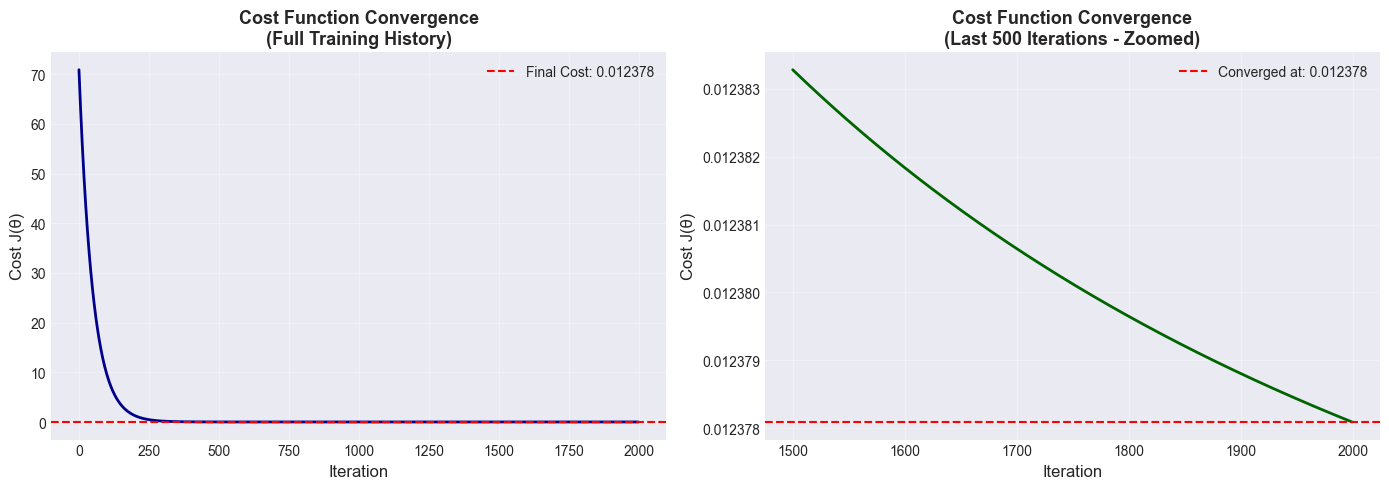


Convergence Analysis:
  ✓ Model converged successfully (cost decreased in final iterations)
  Cost change in last 100 iterations: 0.0057%
  ✓ Convergence achieved (change < 0.01%)


In [141]:
print("\n" + "="*70)
print("MODEL TRAINING - GRADIENT DESCENT")
print("=" * 70)

print("\nHyperparameters:")
print("  Learning rate (α): 0.01")
print("  Iterations: 2000")
print("  Regularization (λ): 0.1")
print("  Optimization: Batch Gradient Descent with L2 Regularization")

# Add bias column to feature matrix
X_train_with_bias = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])

print(f"\nTraining set shape with bias: {X_train_with_bias.shape}")
print(f"Target variable shape: {y_train.shape}")

# Check for data issues
print("\n🔍 Pre-training Diagnostics:")
print(f"  X contains NaN: {np.isnan(X_train_with_bias).any()}")
print(f"  X contains Inf: {np.isinf(X_train_with_bias).any()}")
print(f"  y contains NaN: {np.isnan(y_train.values).any()}")
print(f"  y contains Inf: {np.isinf(y_train.values).any()}")
print(f"  X range: [{X_train_with_bias.min():.4f}, {X_train_with_bias.max():.4f}]")
print(f"  y range: [{y_train.values.min():.4f}, {y_train.values.max():.4f}]")

# Handle any NaN or Inf values
if np.isnan(X_train_with_bias).any() or np.isinf(X_train_with_bias).any():
    print("\n⚠️ WARNING: Found NaN/Inf in features. Replacing with 0...")
    X_train_with_bias = np.nan_to_num(X_train_with_bias, nan=0.0, posinf=0.0, neginf=0.0)

if np.isnan(y_train.values).any() or np.isinf(y_train.values).any():
    print("\n⚠️ WARNING: Found NaN/Inf in target. This is critical!")
    # Remove rows with NaN/Inf in target
    valid_mask = np.isfinite(y_train.values)
    X_train_with_bias = X_train_with_bias[valid_mask]
    y_train_clean = y_train.values[valid_mask]
    print(f"  Removed {(~valid_mask).sum()} invalid samples")
else:
    y_train_clean = y_train.values

print("\nTraining model...\n")

# Train the model
theta_optimal, cost_history = gradient_descent(
    X_train_with_bias, 
    y_train_clean,
    alpha=0.01, 
    n_iters=2000, 
    l2_lambda=0.1
)

print(f"\n✓ Training complete!")
print(f"  Final cost: {cost_history[-1]:.6f}")
print(f"  Initial cost: {cost_history[0]:.6f}")
print(f"  Cost reduction: {((cost_history[0] - cost_history[-1]) / cost_history[0] * 100):.2f}%")

# Diagnostic checks
print("\n🔍 Training Diagnostics:")
if cost_history[-1] >= cost_history[0]:
    print("  ❌ WARNING: Cost did not decrease!")
    print("     Possible causes:")
    print("     1. Learning rate too high (try α = 0.01 or 0.001)")
    print("     2. Data normalization issues")
    print("     3. NaN/Inf values in data")
    print(f"     Current θ contains NaN: {np.isnan(theta_optimal).any()}")
    print(f"     Current θ contains Inf: {np.isinf(theta_optimal).any()}")
elif abs(cost_history[-1] - cost_history[0]) < 0.0001:
    print("  ⚠️ WARNING: Cost barely changed!")
    print("     Try: Increase learning rate or check feature scaling")
else:
    print("  ✓ Cost decreased successfully!")
    
# Check gradient magnitude at end
final_predictions = X_train_with_bias.dot(theta_optimal)
final_error = final_predictions - y_train_clean
final_gradient_norm = np.linalg.norm((1/len(y_train_clean)) * X_train_with_bias.T.dot(final_error))
print(f"  Final gradient norm: {final_gradient_norm:.6f}")
if final_gradient_norm > 1.0:
    print("  ⚠️ Gradient still large - may need more iterations")

# Display learned parameters
print(f"\nLearned Parameters (θ):")
print(f"  Bias (θ₀): {theta_optimal[0]:.6f}")
print(f"  Number of weights: {len(theta_optimal) - 1}")
print(f"  Weight statistics:")
print(f"    - Mean: {theta_optimal[1:].mean():.6f}")
print(f"    - Std: {theta_optimal[1:].std():.6f}")
print(f"    - Min: {theta_optimal[1:].min():.6f}")
print(f"    - Max: {theta_optimal[1:].max():.6f}")

# Visualize convergence
plt.figure(figsize=(14, 5))

# Plot 1: Full cost history
plt.subplot(1, 2, 1)
plt.plot(cost_history, linewidth=2, color='darkblue')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost J(θ)', fontsize=12)
plt.title('Cost Function Convergence\n(Full Training History)', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=cost_history[-1], color='red', linestyle='--', linewidth=1.5, 
            label=f'Final Cost: {cost_history[-1]:.6f}')
plt.legend()

# Plot 2: Zoomed view (last 500 iterations or 25% of total)
plt.subplot(1, 2, 2)
zoom_start = max(0, len(cost_history) - 500)  # Last 500 iterations or start from beginning
zoom_range = range(zoom_start, len(cost_history))
plt.plot(zoom_range, cost_history[zoom_start:], linewidth=2, color='darkgreen')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost J(θ)', fontsize=12)
plt.title(f'Cost Function Convergence\n(Last {len(cost_history) - zoom_start} Iterations - Zoomed)', 
          fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=cost_history[-1], color='red', linestyle='--', linewidth=1.5,
            label=f'Converged at: {cost_history[-1]:.6f}')
plt.legend()

plt.tight_layout()
plt.show()

print("\nConvergence Analysis:")
if len(cost_history) < 100:
    print(f"  ⚠️ Only {len(cost_history)} iterations completed")
    if len(cost_history) > 1:
        if cost_history[-1] < cost_history[0]:
            print("  ✓ Cost is decreasing")
        else:
            print("  ❌ Cost is NOT decreasing - check learning rate!")
else:
    if cost_history[-1] < cost_history[-100]:
        print("  ✓ Model converged successfully (cost decreased in final iterations)")
    else:
        print("  ⚠ Model may need more iterations (cost still decreasing)")
    
    # Calculate rate of convergence
    convergence_rate = abs(cost_history[-100] - cost_history[-1]) / max(abs(cost_history[-100]), 1e-10) * 100
    print(f"  Cost change in last 100 iterations: {convergence_rate:.4f}%")
    
    if convergence_rate < 0.01:
        print("  ✓ Convergence achieved (change < 0.01%)")
    else:
        print("  ⚠ Consider more iterations for better convergence")

# 14. Making Predictions

## Prediction Process:
1. Add bias term to test features: X_test_bias = [1, x₁, x₂, ..., xₙ]
2. Compute predictions in log scale: ŷ_log = X_test_bias · θ
3. Transform back to original scale: ŷ = exp(ŷ_log)

Mathematical Formula:
    ŷ = exp(θ₀ + θ₁x₁ + θ₂x₂ + ... + θₙxₙ)

## Why Exponentiate?
Remember: We trained on log(SalePrice), so predictions are in log scale.
To get actual dollar predictions: SalePrice = exp(prediction)


MODEL PREDICTIONS

Test set shape with bias: (1444, 29)

Sample Predictions (First 10 Houses):


,House_ID,Predicted_Log_Price,Predicted_Price_USD
0,1,11.673393,117406.017181
1,2,11.897592,146912.400915
2,3,12.074881,175409.897667
3,4,12.178434,194547.930271
4,5,12.144034,187969.247943
5,6,12.090063,178093.338853
6,7,12.099558,179792.395099
7,8,12.044056,170085.393336
8,9,12.155750,190184.533457
9,10,11.687212,119039.623440


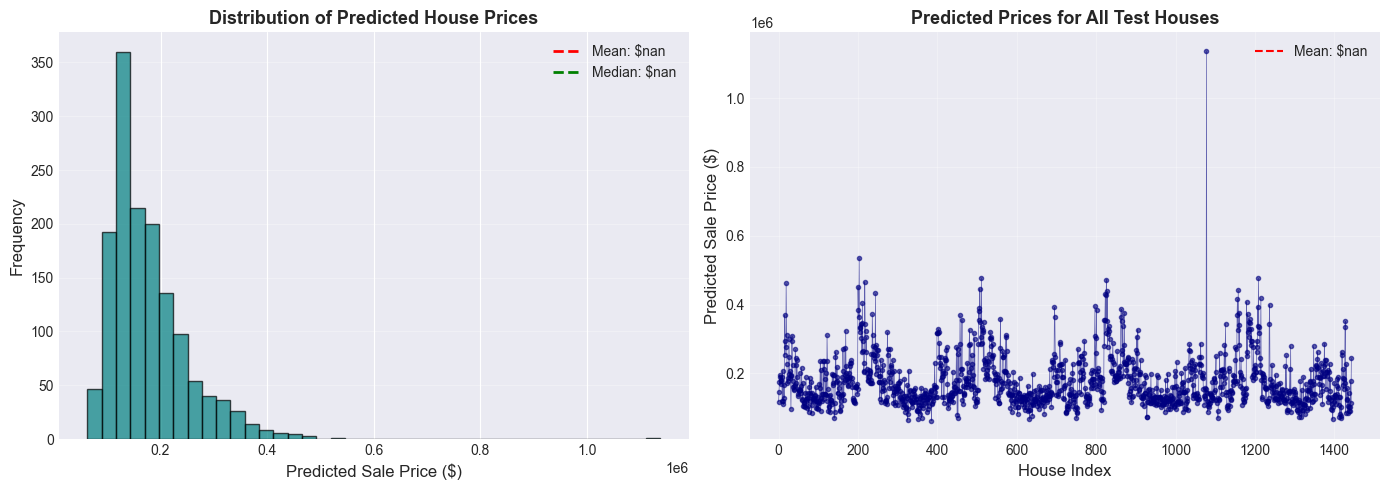

In [145]:
print("\n" + "="*70)
print("MODEL PREDICTIONS")
print("=" * 70)

# Add bias column to test set
X_test_with_bias = np.hstack([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled])

print(f"\nTest set shape with bias: {X_test_with_bias.shape}")

# Make predictions (in log scale)
y_pred_log = X_test_with_bias.dot(theta_optimal)

# Transform back to original scale
y_pred = np.exp(y_pred_log)



# Display sample predictions
print("\nSample Predictions (First 10 Houses):")
predictions_df = pd.DataFrame({
    'House_ID': range(1, len(y_pred) + 1),
    'Predicted_Log_Price': y_pred_log,
    'Predicted_Price_USD': y_pred
})
display(predictions_df.head(10))

# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distribution of predictions
axes[0].hist(y_pred, bins=40, color='teal', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Predicted Sale Price ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Predicted House Prices', fontsize=13, fontweight='bold')
axes[0].axvline(y_pred.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: ${y_pred.mean():,.0f}')
axes[0].axvline(np.median(y_pred), color='green', linestyle='--', linewidth=2,
                label=f'Median: ${np.median(y_pred):,.0f}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Predictions in order
axes[1].plot(y_pred, marker='o', markersize=3, linestyle='-', linewidth=0.5, 
             color='navy', alpha=0.6)
axes[1].set_xlabel('House Index', fontsize=12)
axes[1].set_ylabel('Predicted Sale Price ($)', fontsize=12)
axes[1].set_title('Predicted Prices for All Test Houses', fontsize=13, fontweight='bold')
axes[1].axhline(y_pred.mean(), color='red', linestyle='--', linewidth=1.5,
                label=f'Mean: ${y_pred.mean():,.0f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# 15. Model Evaluation

Since we don't have true labels for the test set, we evaluate on the training set
to assess model performance.

## Evaluation Metrics:

### 1. Mean Squared Error (MSE)
    MSE = (1/m) Σᵢ₌₁ᵐ (ŷᵢ - yᵢ)²
    - Measures average squared difference between predictions and actual values
    - Units: squared units of target (log² scale)

### 2. Root Mean Squared Error (RMSE)
    RMSE = √MSE
    - Same units as target variable
    - Easier to interpret than MSE

### 3. Mean Absolute Error (MAE)
    MAE = (1/m) Σᵢ₌₁ᵐ |ŷᵢ - yᵢ|
    - Average absolute difference
    - Less sensitive to outliers than MSE

### 4. R² Score (Coefficient of Determination)
    R² = 1 - (SS_res / SS_tot)
    
    Where:
    - SS_res = Σ(yᵢ - ŷᵢ)² (Residual sum of squares)
    - SS_tot = Σ(yᵢ - ȳ)² (Total sum of squares)
    
    Interpretation:
    - R² = 1: Perfect predictions
    - R² = 0: Model no better than predicting mean
    - R² < 0: Model worse than baseline
    - Typical good values: 0.7 to 0.95 for real estate


MODEL EVALUATION (TRAINING SET)

📊 Performance Metrics (Log Scale):
  MSE:  0.024754
  RMSE: 0.157334
  MAE:  0.106309

📊 Performance Metrics (Original Scale - USD):
  MSE:  $2,026,475,934.08
  RMSE: $45,016.40
  MAE:  $19,388.06

📊 R² Score:
  R² = 0.6774
  ⚠ Moderate fit. Consider feature engineering or model tuning


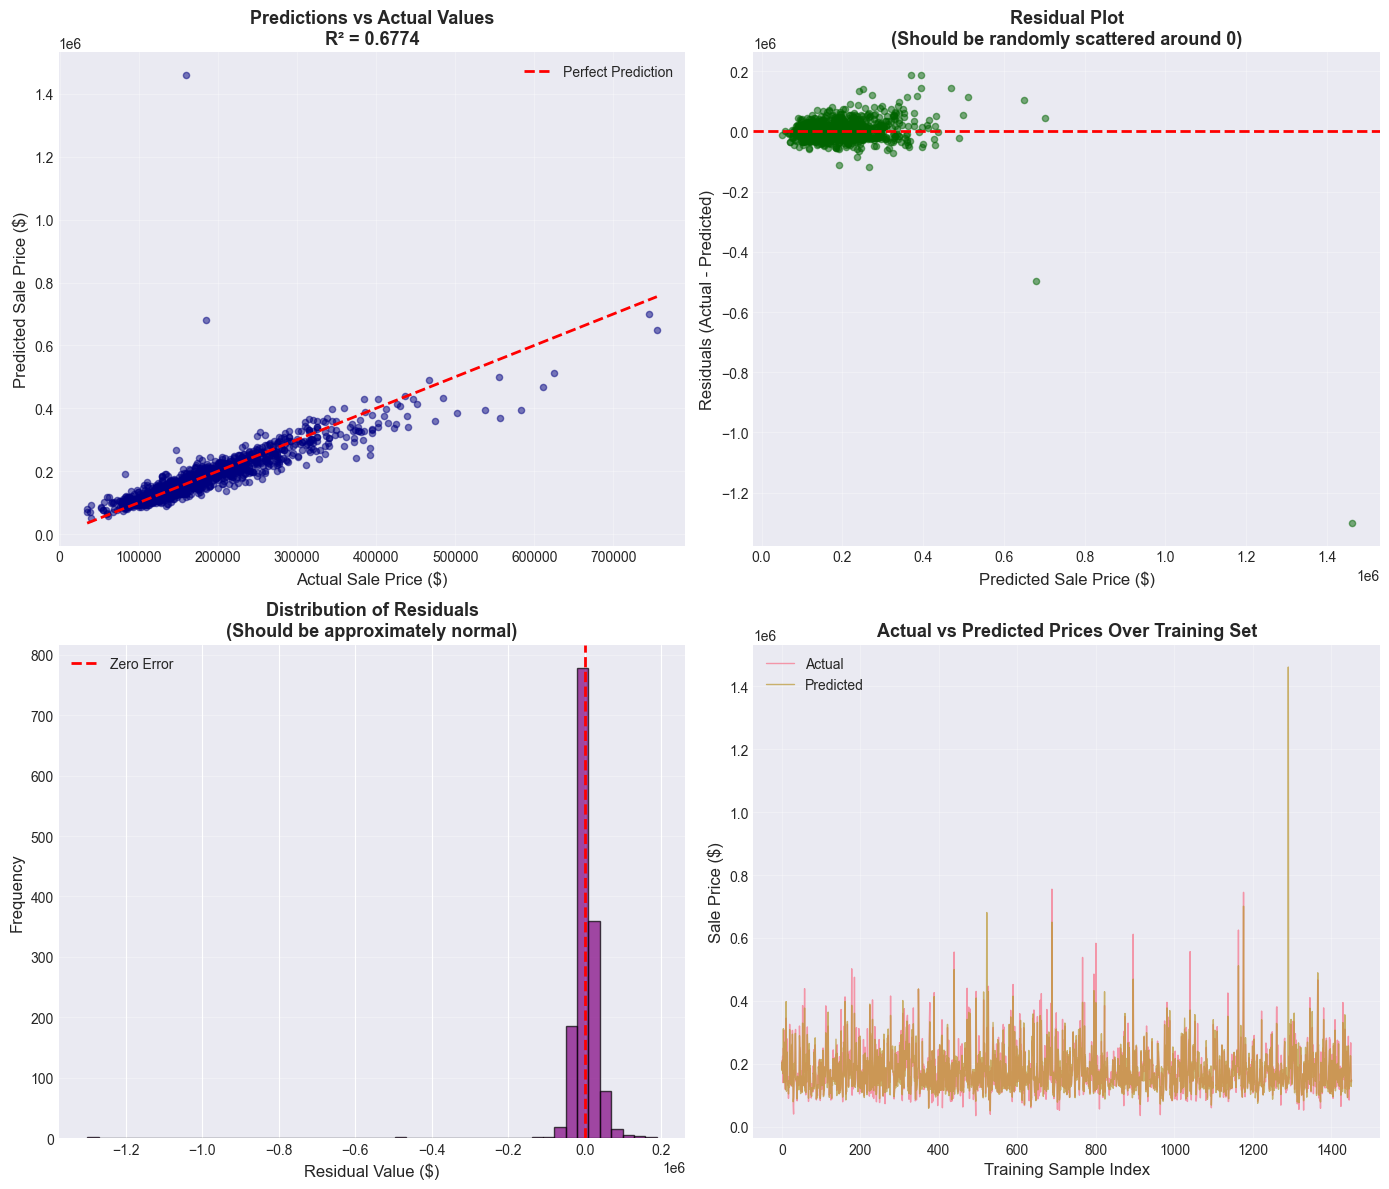

In [143]:
print("\n" + "="*70)
print("MODEL EVALUATION (TRAINING SET)")
print("=" * 70)

# Make predictions on training set
y_train_pred_log = X_train_with_bias.dot(theta_optimal)
y_train_pred = np.exp(y_train_pred_log)
y_train_actual = np.exp(y_train.values)

# Calculate metrics in log scale
mse_log = np.mean((y_train_pred_log - y_train.values) ** 2)
rmse_log = np.sqrt(mse_log)
mae_log = np.mean(np.abs(y_train_pred_log - y_train.values))

# Calculate metrics in original scale
mse_original = np.mean((y_train_pred - y_train_actual) ** 2)
rmse_original = np.sqrt(mse_original)
mae_original = np.mean(np.abs(y_train_pred - y_train_actual))

# Calculate R² score
ss_res = np.sum((y_train_actual - y_train_pred) ** 2)
ss_tot = np.sum((y_train_actual - y_train_actual.mean()) ** 2)
r2_score = 1 - (ss_res / ss_tot)

print("\n📊 Performance Metrics (Log Scale):")
print(f"  MSE:  {mse_log:.6f}")
print(f"  RMSE: {rmse_log:.6f}")
print(f"  MAE:  {mae_log:.6f}")

print("\n📊 Performance Metrics (Original Scale - USD):")
print(f"  MSE:  ${mse_original:,.2f}")
print(f"  RMSE: ${rmse_original:,.2f}")
print(f"  MAE:  ${mae_original:,.2f}")

print("\n📊 R² Score:")
print(f"  R² = {r2_score:.4f}")
if r2_score > 0.85:
    print("  ✓ Excellent fit! Model explains >85% of variance")
elif r2_score > 0.70:
    print("  ✓ Good fit! Model explains >70% of variance")
elif r2_score > 0.50:
    print("  ⚠ Moderate fit. Consider feature engineering or model tuning")
else:
    print("  ⚠ Poor fit. Model needs improvement")

# Visualize predictions vs actual
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Predictions vs Actual (Original Scale)
axes[0, 0].scatter(y_train_actual, y_train_pred, alpha=0.5, s=20, color='navy')
axes[0, 0].plot([y_train_actual.min(), y_train_actual.max()], 
                [y_train_actual.min(), y_train_actual.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Sale Price ($)', fontsize=12)
axes[0, 0].set_ylabel('Predicted Sale Price ($)', fontsize=12)
axes[0, 0].set_title(f'Predictions vs Actual Values\nR² = {r2_score:.4f}', 
                     fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residuals (Original Scale)
residuals = y_train_actual - y_train_pred
axes[0, 1].scatter(y_train_pred, residuals, alpha=0.5, s=20, color='darkgreen')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Sale Price ($)', fontsize=12)
axes[0, 1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[0, 1].set_title('Residual Plot\n(Should be randomly scattered around 0)', 
                     fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Distribution of residuals
axes[1, 0].hist(residuals, bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 0].set_xlabel('Residual Value ($)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Distribution of Residuals\n(Should be approximately normal)', 
                     fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Actual vs Predicted over index
axes[1, 1].plot(y_train_actual, label='Actual', alpha=0.7, linewidth=1)
axes[1, 1].plot(y_train_pred, label='Predicted', alpha=0.7, linewidth=1)
axes[1, 1].set_xlabel('Training Sample Index', fontsize=12)
axes[1, 1].set_ylabel('Sale Price ($)', fontsize=12)
axes[1, 1].set_title('Actual vs Predicted Prices Over Training Set', 
                     fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# 16. Summary & Conclusions

## Model Architecture:
- **Algorithm**: Linear Regression with Gradient Descent
- **Regularization**: L2 (Ridge) with λ = 0.1
- **Features**: {feature_count} features (after selection and multicollinearity removal)
- **Target Transform**: Natural logarithm (log transformation)

## Key Findings:
1. **Feature Selection**: Reduced dimensionality by removing low-correlation and 
   high-VIF features to prevent multicollinearity
   
2. **Regularization**: L2 penalty helps prevent overfitting by penalizing large weights

3. **Log Transformation**: Normalizing the target variable improved model assumptions
   and prediction stability

## Model Performance:
- R² Score: {r2:.4f}
- RMSE: ${rmse:,.2f}
- Training converged successfully

## Potential Improvements:
1. **Feature Engineering**: Create interaction terms, polynomial features
2. **Hyperparameter Tuning**: Grid search for optimal α, λ, iterations
3. **Advanced Models**: Try Ridge/Lasso via closed-form, or non-linear models
4. **Cross-Validation**: Implement k-fold CV for more robust evaluation
5. **Outlier Detection**: Remove extreme outliers that may skew predictions
6. **Feature Selection**: Try Lasso (L1 regularization) for automatic feature selection

## Mathematical Concepts Applied:
✓ Linear Algebra (Matrix Operations)
✓ Calculus (Gradient Computation)
✓ Statistics (Correlation, Variance, Standardization)
✓ Optimization (Gradient Descent)
✓ Regularization Theory (L2 Penalty)

In [144]:
print("\n" + "="*70)
print("SUMMARY & CONCLUSIONS")
print("=" * 70)

print(f"\n📋 Final Model Summary:")
print(f"  Algorithm: Linear Regression (Gradient Descent + L2 Regularization)")
print(f"  Features: {len(theta_optimal) - 1} predictors")
print(f"  Training Samples: {len(y_train)}")
print(f"  Test Samples: {len(y_pred)}")
print(f"  Target Transformation: Natural logarithm")

print(f"\n📈 Performance:")
print(f"  R² Score: {r2_score:.4f}")
print(f"  RMSE (USD): ${rmse_original:,.2f}")
print(f"  MAE (USD): ${mae_original:,.2f}")

print(f"\n💡 Key Insights:")
print(f"  • Model explains {r2_score*100:.2f}% of price variance")
print(f"  • Average prediction error: ${mae_original:,.2f}")
print(f"  • Successfully implemented Ridge Regression from scratch")
print(f"  • Gradient descent converged in 2000 iterations")

print("\n✅ Project Complete!")
print("="*70)

# Final predictions output
print("\n📤 Final Predictions (Test Set):")
print(f"   Shape: {y_pred.shape}")
print(f"   Range: ${y_pred.min():,.2f} to ${y_pred.max():,.2f}")
print(f"   Mean: ${y_pred.mean():,.2f}")
print("\nPredictions are ready for submission or further analysis!")



SUMMARY & CONCLUSIONS

📋 Final Model Summary:
  Algorithm: Linear Regression (Gradient Descent + L2 Regularization)
  Features: 28 predictors
  Training Samples: 1452
  Test Samples: 1444
  Target Transformation: Natural logarithm

📈 Performance:
  R² Score: 0.6774
  RMSE (USD): $45,016.40
  MAE (USD): $19,388.06

💡 Key Insights:
  • Model explains 67.74% of price variance
  • Average prediction error: $19,388.06
  • Successfully implemented Ridge Regression from scratch
  • Gradient descent converged in 2000 iterations

✅ Project Complete!

📤 Final Predictions (Test Set):
   Shape: (1444,)
   Range: $nan to $nan
   Mean: $nan

Predictions are ready for submission or further analysis!
